In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.interpolate import interp1d
import sys
import os
import re
import warnings

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 

# Settings
colors = ["windows blue", "amber", "green", "dusty purple", "cyan", "electric pink"]
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
sns.set_palette(sns.xkcd_palette(colors))
colors = ['C'+str(i) for i in range(len(colors))]

In [3]:
#---------------#
#  Import data  #
#---------------#


#--- Site information
sites= pd.read_excel('data/MTF_database.xlsx',sheet_name='Site_information',header=[0],)
sites.loc[sites['Site name'].isna(),'Site name'] = ''
sites.columns

Index(['Continent', 'Country', 'Region', 'Site name', 'Y coords', 'X coords',
       'Minimum height', 'Minimum diameter', 'Maximum diameter',
       'Dominant species', 'Dominant species % of total',
       'Dominant_mortality cause', 'Management', 'N_plots', 'Plot_area',
       'ntree_Total', 'Remeasurement_interval_avg', 'survey_duration_total',
       'survey_start_yr', 'survey_end_yr', 'Elevation', 'Paper_T°C',
       'Paper_precip_mm', 'Reference'],
      dtype='object')

In [4]:
#--- Subset data
subset = sites[['Reference', 'survey_start_yr', 'survey_end_yr']].copy()
subset = subset.groupby('Reference').first().reset_index()
subset.head()

start = subset[['Reference', 'survey_start_yr']]
end = subset[['Reference', 'survey_end_yr']]
end.columns = 'Reference', 'survey_yr'
start.columns = 'Reference', 'survey_yr'
subset = pd.concat([start,end],axis=0)
subset = subset.dropna(axis=0)

# Sort dataframe by end of the survey year
start_no_na = start.dropna()
start_dict = {i:j for i,j in zip(start_no_na['Reference'],start_no_na['survey_yr'])}

ss = subset.groupby(['Reference','survey_yr']).min().reset_index()
ss['start'] = ss.Reference.apply(lambda x: start_dict[x])
ss = ss.sort_values('start', ascending=True)


#--- Format citations for ylabels
refs = list(ss.Reference.unique())
special_authors_dict = {'Bull':'Bull', 
                        'Lamberty':'Bond-Lamberty and Gower',
                        #'Brown':'Brown, Kertis et al.',
                        #'Campbell':'Campbell, Fontaine et al.',
                        'Chambers':'Chambers and Mast',
                        #'Cline':'Cline, Berg et al.',
                        'Conner':'Conner and Saenz',
                        #'Dobbertin':'Dobbertin, Baltensweiler et al.',
                        'Dunn':'Dunn and Bailey',
                        'Fassnacht':'Fassnacht and Steele',
                        'Ganey':'Ganey and Vojta',
                        #'Garber':'Garber, Brown et al.',
                        #'Grayson':'Grayson, Cluck et al.',
                        #'Hararuk':'Hararuk, Kurz et al.',
                        'Harrington':'Harrington',
                        'Hart':'Hart and Hart',
                        'Hogg':'Hogg and Michaelian',
                        #'Holeksa':'Holeksa, Zielonka et al.',
                        'Huggard':'Huggard',
                        #'Kearns': 'Kearns, Jacobi et al.',
                        #'Landram': 'Landram, Laudenslayer et al.',
                        'Lyon':'Lyon',
                        #'Metsaranta':'Metsaranta, Lieffers et al.',
                        'Mitchell':'Mitchell and Preisler',
                        #'Gonzalez':'Molinas-Gonzalez et al.',
                        #'Newbery':'Newbery, Lewis et al.',
                        'Onodera':'Onodera and Tokuda',
                        #'Palace':'Palace, Keller et al.',
                        'Raphael':'Raphael and Morrison',
                        'Ritchie':'Ritchie and Knapp',
                        'Schroeder':'Schroeder',
                        'Sinclair':'Sinclair',
                        #'Slaughter':'Slaughter, Grigal et al.',
                       # 'Smith':'Smith, Moroni et al.',
                       # 'Rumann':'Stevens-Rumann et al.',
                        'Taylor':'Taylor and MacLean',
                        #'Vanderwel':'Vanderwel, Malcolm et al.',
                        'Wilson': 'Wilson and McComb',
                        'Yamasaki':'Yamasaki and Leak',
                       }

refs_formatted_ylabels = np.empty((len(refs),),dtype='object')
for i,ref in enumerate(refs):
    
    split_string = re.findall('([A-Z][a-zá-ÿ]+)([0-9]+)', ref, re.UNICODE)
    
    if split_string[0][0] in special_authors_dict.keys() :
        refs_formatted_ylabels[i] = str(special_authors_dict[split_string[0][0]])+', '+str(split_string[0][1])
        
    else:
        refs_formatted_ylabels[i] = str(split_string[0][0])+' et al., '+str(split_string[0][1])

In [5]:
mtf_subset = sites[['Reference', 'survey_start_yr', 'survey_end_yr', 'X coords', 'Y coords']]

print('All refs with start and year: ', len(ss.Reference.unique()))
print('Refs no location: ',len(mtf_subset[(mtf_subset['X coords'].isna())].Reference.unique()))

print('Refs no location but survey start and end: ', 
      len(mtf_subset[(mtf_subset['X coords'].isna()) & (mtf_subset.survey_start_yr.notna())].Reference.unique()))
print('Refs with location but NO survey start and end: ', 
      len(mtf_subset[(mtf_subset['X coords'].notnull()) & (mtf_subset.survey_start_yr.isna())].Reference.unique()))
print('Refs no start and end year: ', len(mtf_subset[(mtf_subset['survey_start_yr'].isna())].Reference.unique()))

All refs with start and year:  59
Refs no location:  5
Refs no location but survey start and end:  3
Refs with location but NO survey start and end:  9
Refs no start and end year:  11


# Plotting just bars

/var/folders/wv/lh5tf82928n8gw91c0nbgs4h0000gn/T/ipykernel_36503/571242135.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1900,2040,20),color='k')


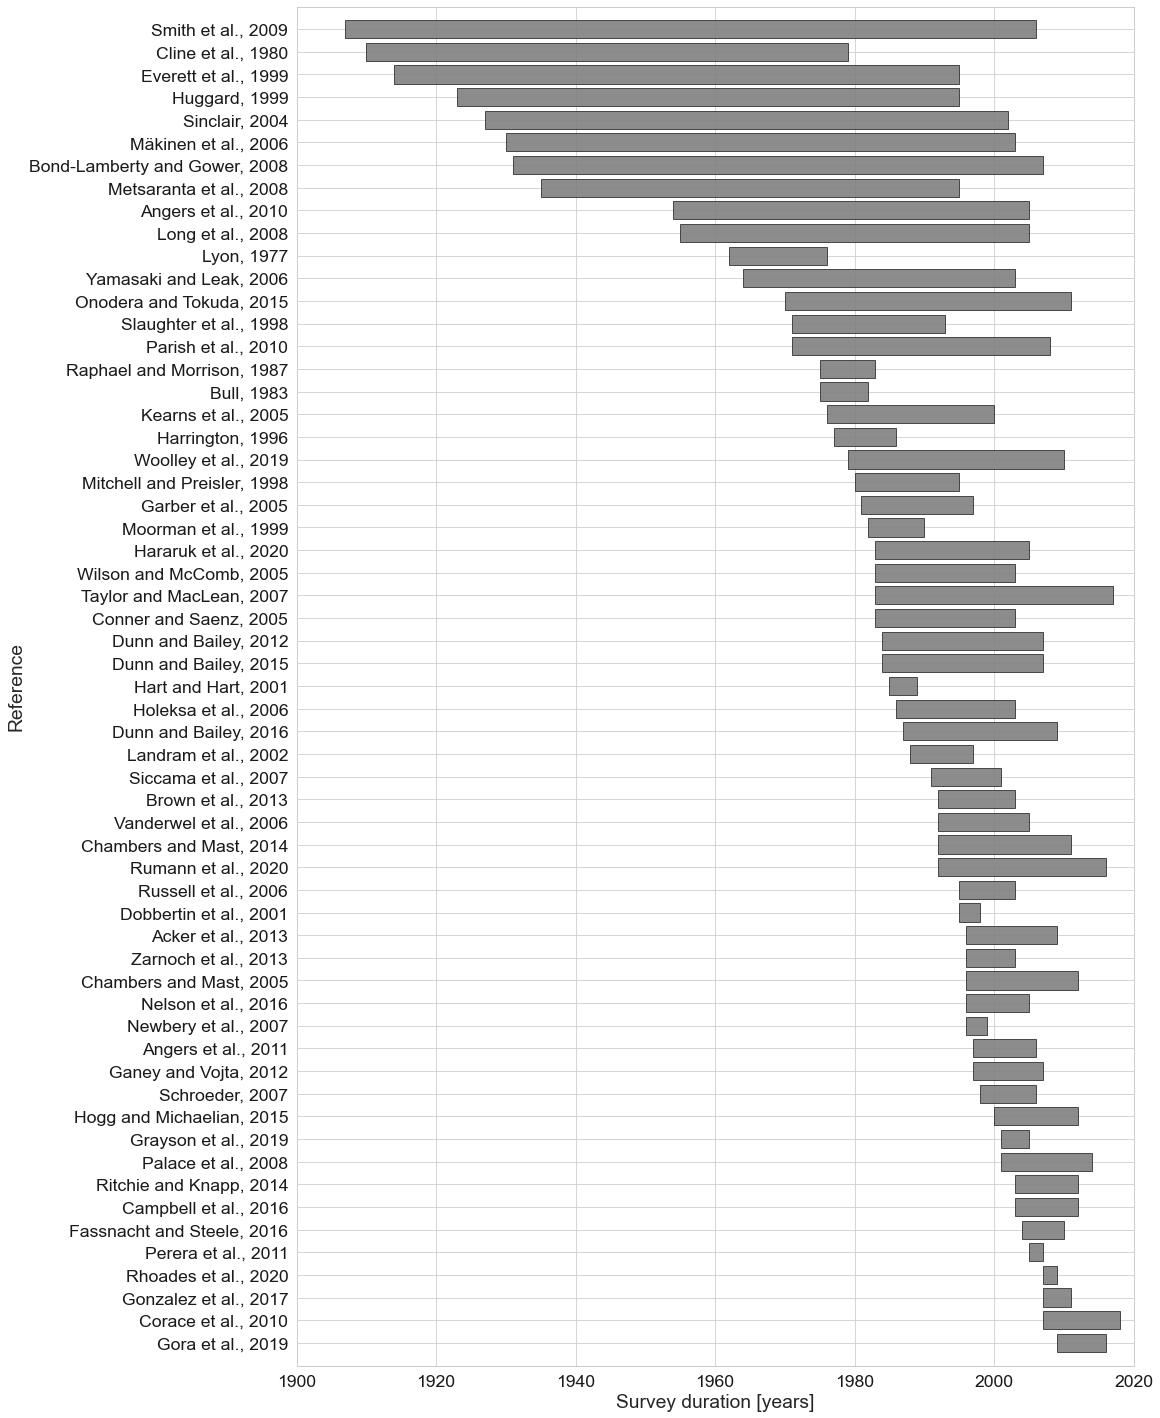

In [6]:
ss_obs = ss[~(ss.survey_yr == ss.start)].reset_index(drop=True)
ss_obs.columns = ['Reference', 'end', 'start']
ss_obs['duration'] = ss_obs.end - ss_obs.start
ss_obs = ss_obs[['start','end','duration','Reference']]

sns.set_context("paper", font_scale=2)

cm = sns.color_palette("hls", len(ss_obs))[::-1]
cm = sns.color_palette("Blues", len(ss_obs))
cm = sns.color_palette("GnBu", len(ss_obs))


fig, ax = plt.subplots(1,1,figsize=(15,25))
plt.barh(np.arange(0,len(ss_obs)), ss_obs.duration.to_list()[::-1], left=ss_obs.start.to_list()[::-1], 
         color='grey', alpha=0.9, edgecolor='k', 
        # height=0.8
        )
plt.xlim(1900,2020)
plt.ylim(-1,len(ss_obs))

ax.grid(True, axis='both')
ax.set_xticklabels(np.arange(1900,2040,20),color='k')
ax.set_yticks(np.arange(0,len(ss_obs)))
ax.set_yticklabels(refs_formatted_ylabels[::-1], color='k')
ax.set_xlabel('Survey duration [years]')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_ylabel('Reference')
plt.savefig('Appendix_FigureA1_survey_durations.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
print('Mean survey duration was {} years.'.format('%.2f'%ss_obs.duration.mean()))
print('Median survey duration was {} years.'.format('%.2f'%ss_obs.duration.median()))

Mean survey duration was 23.95 years.
Median survey duration was 14.00 years.


In [8]:
sites_refs = sites.groupby(['Reference']).first().reset_index()
sites_refs.Remeasurement_interval_avg.mean()

4.06991988576666